In [4]:
%load_ext tensorboard
import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import numpy as np
import dataset
import os

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [5]:
import importlib
importlib.reload(dataset) 

MAXLEN = 50
BATCH_SIZE = 64  # 512
files = ['texts/' + f for f in os.listdir('texts/')]  # short_table.txt', 'texts/treasure_island.txt', 'texts/ahava.txt', 'texts/rambam_mamre.txt', 'texts/ali_baba.txt', 'texts/bible.txt']

data = dataset.load_file(BATCH_SIZE, 0.1, maxlen=MAXLEN, filenames=files)


In [47]:
l2 = tf.keras.regularizers.l2

EMBED_DIM = 2**9  # larger -> quicker opening. knee at 1024
UNITS = 2**9

inp = tf.keras.Input(shape=(data.input_texts.shape[1],), batch_size=BATCH_SIZE)

embedding = layers.Embedding(len(data.letters_table), EMBED_DIM, mask_zero=True)(inp)

rnn_0 = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, recurrent_regularizer=None), merge_mode='sum')(embedding)  # =l2(1e-6)
rnn_0 = layers.Dropout(0.4)(rnn_0) 

rnn_1 = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, recurrent_regularizer=None), merge_mode='sum')(rnn_0)
rnn_1 = layers.Dropout(0.1)(rnn_1)

add = layers.Add()([rnn_0, rnn_1])

dense_1 = layers.Dense(UNITS, activation='relu', kernel_regularizer=l2(5e-5))(add)
dense_1 = layers.Dropout(0.1)(dense_1)
#h = layers.Add()([h1, h])
# for k in range(1):
#     h = layers.Add()([h, Dense(256)(h)])

output_niqqud = layers.Dense(data.niqqud_texts.shape[2], name='N')(dense_1)
output_dagesh = layers.Dense(data.dagesh_texts.shape[2], name='D')(rnn_0)

model = tf.keras.Model(inputs=[inp], outputs=[output_niqqud, output_dagesh])
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='mean_squared_logarithmic_error', optimizer=adam, metrics=['accuracy'])

plot_model(model, to_file='model.png')
model.summary()


Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(64, 50)]           0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (64, 50, 512)        38400       input_21[0][0]                   
__________________________________________________________________________________________________
bidirectional_40 (Bidirectional (64, 50, 512)        3151872     embedding_20[0][0]               
__________________________________________________________________________________________________
dropout_60 (Dropout)            (64, 50, 512)        0           bidirectional_40[0][0]           
___________________________________________________________________________________________

In [48]:

# log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
def fit(EPOCHS):
    return model.fit(data.input_texts, [data.niqqud_texts, data.dagesh_texts],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(data.input_validation, [data.niqqud_validation,  data.dagesh_validation]),
          callbacks=[
              # tf.keras.callbacks.ModelCheckpoint(filepath='niqqud_checkpoints/ckpt_{epoch}', save_weights_only=True),
              # tf.keras.callbacks.EarlyStopping(patience=2, verbose=1), # monitor='accuracy', 
              # tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=0, min_lr=0.0001), # monitor='loss', 
              # tensorboard_callback,
          ]
    )

history = fit(EPOCHS=1)

Train on 132307 samples, validate on 14701 samples
132307/132307 [==============================] - 172s 1ms/sample - loss: 0.0135 - N_loss: 0.0056 - D_loss: 0.0075 - N_accuracy: 0.8696 - D_accuracy: 0.9611 - val_loss: 0.0087 - val_N_loss: 0.0031 - val_D_loss: 0.0053 - val_N_accuracy: 0.9299 - val_D_accuracy: 0.9722


In [ ]:
history1 = fit(EPOCHS=5)

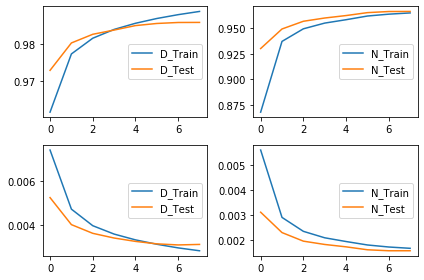

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2)

for n, v in enumerate(['accuracy', 'loss'], 0):
    for n1, t in enumerate(['D', 'N'], 0):
        p = ax[n][n1]  # plt.subplot(1, 4, i)
        p.plot(history.history[t + '_' + v][0:])
        p.plot(history.history['val_' + t + '_' +  v][0:])
        # p.title('Model ' + t + ' ' + v)
        # p.ylabel(v)
        # p.xlabel('Epoch')
        p.legend([t + '_Train', t + '_Test'], loc='center right')

plt.tight_layout()

In [22]:

model = tf.keras.Model(inputs=[inp], outputs=[tf.keras.layers.Softmax()(output_niqqud), tf.keras.layers.Softmax()(output_dagesh)])

def print_predictions(k):
    s = slice(k*BATCH_SIZE, (k+1)*BATCH_SIZE)
    batch = data.input_validation[s]
    [actual_niqqud, actual_dagesh] = model.predict(batch)
    [expected_niqqud, expected_dagesh] = [data.niqqud_validation[s], data.dagesh_validation[s]]
    for a, e in zip(data.merge(batch, ns=actual_niqqud, ds=actual_dagesh), data.merge(batch, ns=expected_niqqud, ds=expected_dagesh)):
        print(a)
        print(e)
        print()

print_predictions(5)

לָהֶן וּצְרִיכִין לְהִתְפַּלֵּל מִנְחָה תְּחִלָּה כִּי בְּהַדְלָקַת הַנֵּרוֹת הִיא
לָהֶן וּצְרִיכִין לְהִתְפַּלֵּל מִנְחָה תְּחִלָּה כִּי בְּהַדְלָקַת הַנֵּרוֹת הִיא

וַחֲמִשָּה כְּשָעַת עֲמִידָה בַּדִּין. הָיָה שוֹוֶה בְּשָעַת הַגְּנֵבָה שְנַיִם,
וַחֲמִשָּה כְּשָעַת עֲמִידָה בַּדִּין. הָיָה שוֹוֶה בְּשָעַת הַגְּנֵבָה שְנַיִם,

עַל פִּי כֵן קוֹנְסִין אוֹתוֹ, וְאוֹסְרִין אֶת הַזֶּרַע; אֲבָל הַבָּסֶר,
עַל פִּי כֵן קוֹנְסִין אוֹתוֹ, וְאוֹסְרִין אֶת הַזֶּרַע; אֲבָל הַבֹּסֶר,

יָדַעְתָּ כִּי-אֵש קָדְחָה בְּאַפִי עֲלֵיכֶם תּוֹקֵד אַתָּה יָדַעְתָּ יְהוָה
יָדָעְתָּ כִּי-אֵש קָדְחָה בְאַפִּי עֲלֵיכֶם תּוּקָד אַתָּה יָדַעְתָּ יְהוָה

בְּמַעֲמְקֵי-מַיִם מַעָרָבֶךָ וְכָל-קַהָלְךָ בְּתוֹכְךְ נָפְלוּ כֹּל יֹשְבֵי
בְּמַעֲמַקֵּי-מָיִם מַעֲרָבֵךְ וְכָל-קְהָלֵךְ בְּתוֹכֵךְ נָפָלוּ כֹּל יֹשְבֵי

כד,ג)--אֶחָד הַכּוֹתֵב בְּיָדוֹ, אוֹ שֶאָמַר לְאַחַר לִכְתֹּב לָהּ, וְאֶחָד
כד,ג)--אֶחָד הַכּוֹתֵב בְּיָדוֹ, אוֹ שֶאָמַר לְאַחֵר לִכְתֹּב לָהּ, וְאֶחָד

בְּדִבּוּרוֹ, וְלֹא יְשְנֵּהוּ. וְאִם נִתְחַיְּבוּ לוֹ אֲחֵ

In [ ]:
# model.load_weights(tf.train.latest_checkpoint('niqqud_checkpoints/'))

In [ ]:
print(history.history['val_accuracy'])

In [ ]:
%tensorboard --logdir logs\fit